In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

En el último capítulo, usamos una combinación lineal de variables independientes para predecir la media de una variable dependiente. Asumimos que en general la variable dependiente se distribuía como una Gaussiana y también exploramos que sucedía al relajar esta condición y usar una distribución t de Student. En este capítulo veremos más ejemplos donde es aconsejable usar distribuciones distintas a las gaussianas. Como veremos pronto, hay un motivo general, o patrón, que se puede usar para generalizar el modelo lineal a muchos problemas.

En el presente capítulo veremos:

* Regresión logística y funciones inversa de enlace
* Regresión logística simple
* Regresión logística múltiple
* La función de softmax y la regresión logística multinomial
* Regresión de Poisson
* Regresión de Poisson cero-inflada



## Modelos lineales generalizados

La principal idea de este capítulo es bastante simple, en lugar de usar una combinación lineal de variables de entrada para predecir la media de una variable de salida, vamos a aplicar una función a la combinación lineal de variables de entrada para predecir la media de la variable de salida:

$$\mu = f(\alpha + X \beta) \tag{4.1}$$

donde $f$ es lo que se conoce como función inversa de enlace. Hay una gran variedad de funciones inversas de enlace que podemos elegir, probablemente la más simple sea la función identidad. Esta es una función que devuelve el mismo valor utilizado como argumento. Todos los modelos del capítulo anterior usaron la función de identidad, y por simplicidad simplemente la omitimos. La función de identidad puede no ser muy útil en sí misma, pero nos permite pensar en varios modelos diferentes de una manera unificada.

¿Por qué llamamos a $f$ _función inversa de enlace_ en lugar de llamarla simplemente función de enlace? La razón es histórica. Tradicionalmente las personas aplican funciones _al otro lado_ de la ecuación $4.1$, y llaman a esas funciones _funciones de enlace_, por lo tanto, para evitar confusiones, nos apegaremos al término función de enlace inverso.

Una situación en la que resulta útil emplear una función inversa de enlace es cuando trabajamos con variables categóricas, como nombres de colores, género, especies biológicas, afiliación política. Ninguna de estas variables es modelada adecuadamente usando una distribución Gaussiana. Si cambiamos la distribución que usamos para modelar los datos, en general necesitaremos también cambiar la forma en que modelamos los valores plausibles para la media de esas distribuciones. Por ejemplo, si usamos una distribución binomial como en el primer y segundo capítulo, necesitaremos un modelo lineal que arroje un valor en el intervalo [0, 1], una forma de lograr esto es mantener el modelo lineal pero usar una función inversa de enlace para restringir la salida al intervalo deseado. Estos trucos no están restringidos a variables discretas, es posible que deseemos modelar datos que solo puedan tomar valores positivos y, por lo tanto, es posible que deseemos restringir el modelo lineal para que devuelva valores positivos para la media de una distribución como por ejemplo las distribuciones Gamma o exponencial.

Antes de continuar, observe que algunas variables pueden codificarse como cuantitativas o cualitativas, y esa es una decisión que debe tomar en función del contexto de su problema; por ejemplo, podemos hablar de las variables categóricas rojas y verdes si estamos hablando de nombres de colores o las cuantitativas de 650 nm y 510 nm si estamos hablando de longitudes de onda.

## Regresión logística

Los problemas de regresión consisten en predecir un valor continuo para una variable de salida dados los valores de una o más variables de entrada. En cambio, la clasificación se trata de asignar un valor discreto (que representa una clase discreta) a una variable de salida dadas algunas variables de entrada. En ambos casos, la tarea es obtener un modelo que capture correctamente la asignación entre las variables de salida y de entrada, para ello tenemos a nuestra disposición una muestra con pares de variables de entrada-salida. Desde una perspectiva de aprendizaje automático, tanto las regresiones como las clasificaciones son ejemplos de algoritmos de aprendizaje supervisado.

Mi madre prepara una comida basada en fideos que es deliciosa y se llama sopa seca. El nombre del plato parece algo ridículo ya que las sopas tienen agua por definición. Sin embargo el nombre adquiere sentido al comprender como se prepara. Algo similar ocurre con la regresión logística cuando se utiliza como método de clasificación.

La regresión logistica es la generalización del modelo de regresión que vimos en el capítulo pasado para cuando la variable dependiente es binaria. Esta generalización se logra en dos pasos. Primero reemplazamos $f$ en $4.1$ por la función logística:

$$ \text{logística}(z) = \frac{1}{1 + e^{-z}} \tag{4.2}$$


Usamos esta función por que una de sus propiedades es que no importa el valor del argumento $z$, el resultado siempre será un valor en el intervalo [0-1]. La función logística es conocida también como función sigmoide, por su aspecto típico de _S_ como se puede ver al ejecutar la siguiente celda:

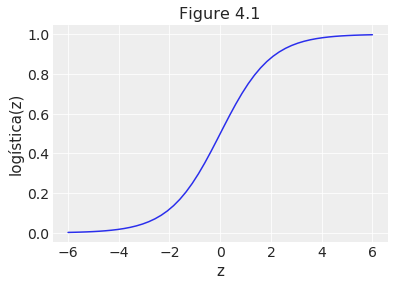

In [2]:
z = np.linspace(-6, 6)
logística = 1 / (1 + np.exp(-z))
plt.plot(z, logística)
plt.xlabel('z')
plt.ylabel('logística(z)')
plt.title('Figure 4.1');

El segundo paso consiste en usar como likelihood una distribución binomial y no una Gaussiana. De esta forma el modelo queda expresado como: 

$$
\theta = logistic(\alpha + x\beta) \\
y = \text{Bern}(\theta) \tag{4.3} 
$$

Esto modelo se puede motivar de la siguiente forma. Si nuestros datos son binarios $y \in \{0, 1\}$, como con el ejemplo de la moneda o el diagnóstico, vemos que tiene sentido usar una distribución bernoulli. Esta distribución está parametrizada por un único parámetro en el intervalo [0, 1], el cual puede ser generado desde un modelo lineal siempre y cuando los valores generados por el modelo lineal sean _comprimidos_ al intervalo [0, 1], algo que puede ser obtenido al emplear una función logística.

Usando un diagrama de Kruschke una regresión logística con priors Gaussianos:


<img alt="regresión_logística" src="imagenes/logística.png" width=250>

## El conjunto de datos del Iris

Vamos a aplicar una regresión logística al conjunto de datos Iris. Este es un conjunto de datos clásico que contiene información sobre flores de 3 especies estrechamente relacionadas: setosa, virginica y versicolor. Estas serán nuestras variables dependientes, las clases que queremos predecir. Tenemos 50 individuos de cada especie y para cada individuo el conjunto de datos contiene cuatro variables (o _features_) que vamos a usar como variables independientes. Estas son el largo del pétalo, el ancho del pétalo, el largo del sépalo y el ancho del sépalo. Por si se lo están preguntando, los sépalos son hojas modificadas, cuya función está generalmente relacionada con la protección de las flores en la yema.

Podemos cargar un DataFrame con el conjunto de datos del iris haciendo:

In [3]:
iris = pd.read_csv('datos/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Ahora graficaremos las 3 especies versus la longitud del sépalo usando la función stripplot de seaborn:

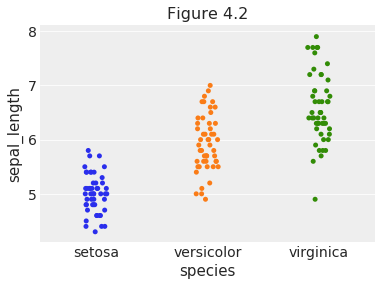

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.title('Figure 4.2');

Observe en la figura 4.2 que en el eje `y` se representan una variable continua mientras que en el eje `x` la variable es categórica. La dispersión (o _jitter_) de los puntos a lo largo del eje `x` no tiene ningún significado, y es solo un _truco_ para evitar que todos los puntos colapsen en una sola línea (pueden probar pasando el argumento `jitter=False`). Por lo tanto lo único que importa al leer el eje `x` es la pertenencia de los puntos a las clases `setosa`, `versicolor` o `virginica`.


Otra forma de inspeccionar los datos es haciendo una matriz de dispersión con la función `pairplot`. En la figura 4.3 podemos ver una matriz de $4 \times 4$, ya que tenemos 4 variables independientes (o _features_). La matriz es simétrica con los triángulos superior e inferior conteniendo la misma información. En la diagonal principal en vez de tener una gráfico de dispersión de una variable contra si misma (lo cual no es informativo) tenemos un KDE de cada feature para cada especie (o clase). Cada especie está representada usando un color particular.

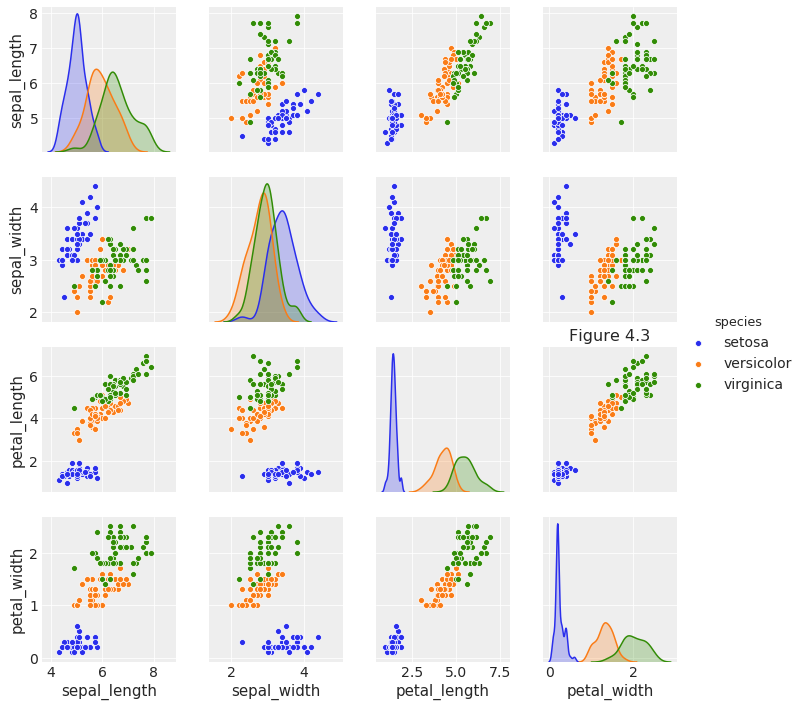

In [5]:
sns.pairplot(iris, hue='species')
plt.title('Figure 4.3');

Antes de continuar, tómese un tiempo para estudiar las gráficas anteriores y familiarizarse con el conjunto de datos y cómo se relacionan las variables dependientes y las independientes.

### El modelo logístico aplicado al conjunto de datos del iris.

Vamos a comenzar con la regresión logística más simple posible: dos clases, setosa y versicolor, y solo una variable independiente, la longitud del sépalo. Como se hace normalmente, vamos a codificar las variables categóricas setosa y versicolor con los números 0 y 1. Usando Pandas podemos hacer:

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

Al igual que con otros modelos lineales, centrar los datos puede ayudar con el muestreo. Ahora que tenemos los datos en el formato adecuado, finalmente podemos construir el modelo con PyMC3.

Observe cómo la primera parte del siguiente modelo se asemeja a un modelo de regresión lineal. Este modelo tiene dos variables deterministas: `θ` y` bd`. `θ` es la salida de la función logística aplicada a la variable `μ` y `bd` es límite de decisión (el cual explicaremos más adelante).Otro punto que vale la pena mencionar es que en lugar de escribir explícitamente la función logística estamos usando `pm.math.sigmoid` (esto es un alias para una función de Theano).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2429.43draws/s]
The acceptance probability does not match the target. It is 0.8787440007578203, but should be close to 0.8. Try to increase the number of tuning steps.


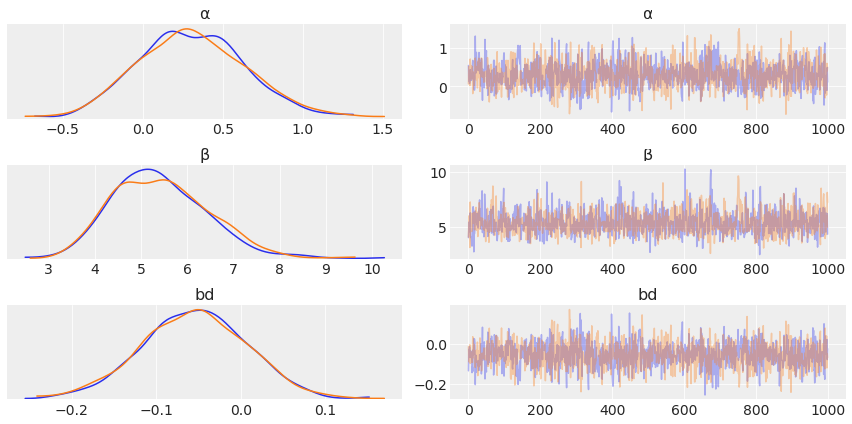

In [7]:
with pm.Model() as modelo_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample(1000)

varnames = ['α', 'β', 'bd']
az.plot_trace(trace_0, varnames);

Como es habitual, también mostramos el summary del posterior. Más adelante, compararemos el valor que obtengamos para el límite de decisión con un valor calculado utilizando otro método.

In [8]:
az.summary(trace_0, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.31,0.34,0.01,-0.31,0.94,1049.0,1.0
β,5.41,1.05,0.03,3.55,7.26,1224.0,1.0
bd,-0.06,0.06,0.00,-0.18,0.06,1367.0,1.0


Ahora vamos a graficar los datos junto con la curva sigmoide ajustada:

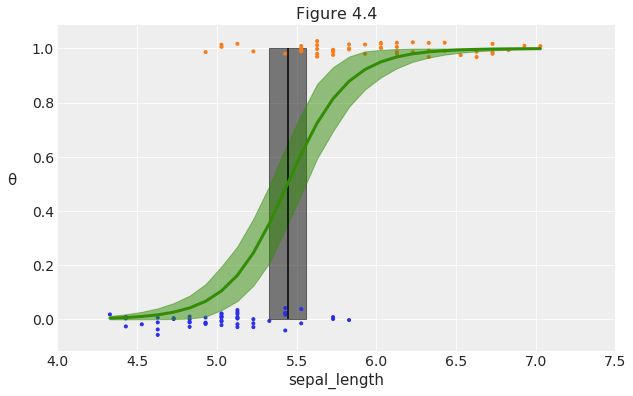

In [9]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.figure(figsize=(10, 6))
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_0['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0, labelpad=20)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.title('Figure 4.4');

La figura 4.4 muestra la longitud del sépalo para las especies (setosa = 0, versicolor = 1). Para mitigar la superposición de los datos, hemos agregado ruido (_jitter_) a las variables-respuesta binarias. Una línea verde en forma de _S_ representa el valor medio de $\theta$. Esta línea se puede interpretar como la probabilidad que una flor sea versicolor dado el valor de la longitud del sépalo. La banda verde semitransparente es el intervalo del 94% de HPD. De esta forma podemos interpretar a la regresión logística como una forma de combinar variables linealmente a fin de obtener una probabilidad para variables binarias.

Alternativamente podemos usar una regresión logística para clasificar, esto lo podemos hacer discretizando el valor de probabilidad obtenido. El caso más común es asignar la clase 1 si la probabilidad es mayor a 0.5 y asignar la clase 0 en caso contrario. En la figura 4.4 hemos graficado este límite de decisión usando una línea vertical negra junto con su 94% HPD (la banda gris). De acuerdo con el límite de decisión, los valores $x_i$ (longitud del sépalo en este caso) a la izquierda corresponden a la clase 0 (setosa) y los valores a la derecha a la clase 1 (versicolor).

El límite de decisión se define como el valor de $x_i$, para el cual $y = 0.5$. Y resulta ser $- \frac{\alpha}{\beta} $, como podemos comprobar a continuación:

A partir de la definición del modelo tenemos la relación:

$$\theta = logistic(\alpha + x \beta) \tag{4.4}$$

Y a partir de la definición de la función logística tenemos que $\theta = 0.5 $, cuando el argumento de la regresión logística es 0, es decir:

$$0.5 = logística(\alpha + x_i \beta) \Leftrightarrow 0 = \alpha + x_i \beta \tag{4.5}$$

Reordenando 4.5, encontramos que el valor de $x_i$, para el cual, $\theta = 0.5$ corresponde a la expresión:

$$x_i = - \frac{\alpha}{\beta} \tag{4.6}$$


Resumiendo los puntos más importantes hasta el momento:

* El valor de $\theta$ es, en términos generales, $p(y= 1 \mid x) $. En este sentido, la regresión logística es en realidad una regresión, solo que estamos _regresionando_ la probabilidad de que un punto de datos pertenezca a la clase 1, dada una combinación lineal de características.

* Estamos modelando la media de una variable dicotómica, es decir, un número en el intervalo [0-1]. Luego, introducimos una regla para convertir esta probabilidad en una asignación de dos clases. En este caso, si $p(y = 1) >= 0.5 $ asignamos clase 1, de lo contrario clase 0.

* No hay nada especial en el valor 0.5, aparte de que es el número en el medio entre 0 y 1. Podemos argumentar que este límite solo es razonable si estamos de acuerdo en cometer un error en una u otra dirección. En otras palabras, si es lo mismo para nosotros clasificar erróneamente una setosa como versicolor o una versicolor como setosa. Resulta que este no es siempre el caso, y el costo asociado a la clasificación errónea no tiene por qué ser simétrico, como recordarán del capítulo 2 cuando analizamos las funciones de pérdida.

# Regresión logística múltiple

De manera similar a la regresión lineal múltiple, la regresión logística múltiple consiste en utilizar más de una variable independiente. Intentemos combinar la longitud del sépalo y el ancho del sépalo. Recuerda que necesitamos preprocesar un poco los datos.

In [10]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width']
#x_n = ['petal_length', 'petal_width']
x_1 = df[x_n].values

## El límite de decisión


No dudes en omitir esta sección y pasar directamente a la implementación del modelo si no estás demasiado interesado en cómo podemos obtener el límite de decisión.

Desde el modelo, tenemos:

$$\theta = logística(\alpha + \beta_1 x_1 + \beta_2 x_2) \tag{4.7}$$

Y a partir de la definición de la función logística, tenemos que $\theta = 0.5$, cuando el argumento de la regresión logística es cero, es decir:

$$ 0.5 = logística(\alpha + \beta_1x_1 + \beta_2x_2) \Leftrightarrow 0 = \alpha + \beta_1x_1 + \beta_2x_2 \tag {4.8}$$

Reordenando, encontramos el valor de $x_2$ para el cual $\theta = 0.5$ el cual corresponde a la expresión:

$$ x_2 = -\frac{\alpha}{\beta_2} + \left (-\frac{\beta_1}{\beta_2} x_1 \right) \tag {4.9}$$

Esta expresión para el límite de decisión tiene la misma forma matemática que la ecuación de una línea, siendo el primer término el intercepto y el segundo la pendiente. Los paréntesis se utilizan para mayor claridad y podemos omitirlos si queremos. Que el límite sea una línea es totalmente razonable, ¿no es así? Si tenemos una sola variable, tenemos datos unidimensionales y podemos dividirla en dos grupos usando un punto; si tenemos dos variables, tenemos un espacio de datos bidimensional y podemos separarlo usando una línea; para las tres dimensiones, el límite será un plano y para dimensiones más altas hablaremos genéricamente acerca de los hiperplanos. Bueno, en realidad siempre podemos hablar de hyperplanos n-dimensionales.

## Implementando el modelo

Para escribir el modelo de regresión logística múltiple utilizando PyMC3, aprovechamos sus capacidades de vectorización, lo que nos permite introducir solo modificaciones menores respecto del modelo logístico simple:

In [11]:
with pm.Model() as modelo_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 422.54draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7132148082485166, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793418851877889, but should be close to 0.8. Try to increase the number of tuning steps.


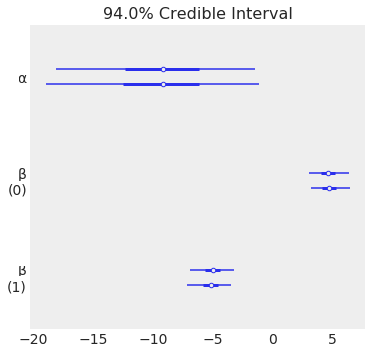

In [12]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

Como hicimos para una única variable predictiva, vamos a graficar los datos y el límite de decisión.

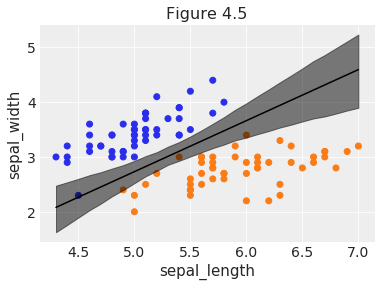

In [13]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 
 
bd_hpd = az.hpd(trace_1['bd'])[idx] 
plt.fill_between(x_1[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='k', alpha=0.5); 
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.title('Figure 4.5');

El límite de decisión es una línea recta, como ya hemos visto. No se confunda con el aspecto curvo de la banda del 94% de HPD. La curvatura aparente es el resultado de tener múltiples líneas que giran alrededor de una región central (aproximadamente alrededor de la media de `x` y la media de `y`).

## Interpretación de los coeficientes de una regresión logística

Debemos tener cuidado al interpretar los coeficientes $\beta$ de una regresión logística. La interpretación no es tan sencilla como con los modelos lineales en el capítulo anterior. La función logística introduce una no linearidad, que debemos tener en cuenta. Si $\beta$ es positivo, aumentar $x$ aumentará $p(y = 1)$ en cierta cantidad, pero la cantidad no es una función lineal de $x$, es en cambio una función no-lineal de $x$. Podemos visualizar este hecho en la figura 4.4, en lugar de una línea con una pendiente constante, tenemos una línea en forma de S con una pendiente que cambia en función de $x$. Un poco de álgebra nos puede dar una idea de cuánto cambia $p(y=1)$ con $\beta$:

El modelo logístico básico es:

$$\theta = logistic (\alpha + X \beta) \tag{4.11} $$

El inverso de la logística es la función logit, que es:

$$ logit(z) = log \left (\frac{z}{1-z} \right) \tag{4.12}$$

Por lo tanto, si tomamos la primera ecuación en esta sección y aplicamos la función logit a ambos términos, obtenemos:

$$ logit(\theta) = \alpha + X \beta \tag{4.13}$$

O equivalente:

$$ log \left (\frac{\theta} {1-\theta} \right) = \alpha + X \beta \tag {4.14}$$

Recuerden que $\theta$ en nuestro modelo era la probabilidad de $y = 1 $, por lo tanto:

$$ log \left(\frac {p(y = 1)} {1-p (y = 1)} \right) = \alpha + X \beta \tag {4.15} $$

La cantidad $$\frac{p (y = 1)} {1-p (y = 1)}$$ se conoce como **odds**. Los odds a favor se definen como la relación entre la probabilidad de éxito y la probabilidad de no éxito. Mientras que la probabilidad de obtener 2 tirando un dado es 1/6, los odds para el mismo evento son $\frac{1/6}{5/6} \simeq 0.2$ o dicho de otra forma 1 evento favorable frente a 5 eventos desfavorables. Los odds suelen ser utilizadas por los jugadores principalmente porque proporcionan una herramienta más intuitiva que las probabilidades _en bruto_ cuando se piensa en la forma correcta de apostar.

> En una regresión logística, el coeficiente $\beta$ codifica el aumento en unidades de log-odds por unidad de aumento de la variable $x$.

La transformación de probabilidad a odds es una transformación monotónica, lo que significa que las probabilidades aumentan a medida que aumenta la probabilidad. Mientras que las probabilidades están restringidas al intervalo $[0, 1]$, los odds viven en el intervalo $[0, \infty]$. El logaritmo es otra transformación monótonica y los log-odds están en el intervalo $[-\infty, \infty]$. La figura 4.6 muestra cómo la probabilidad está relacionada con los odds y los log-odds.

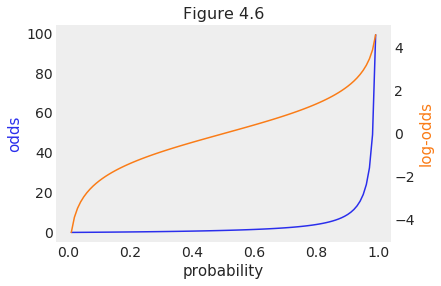

In [14]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.title('Figure 4.6');

Por lo tanto, los valores de los coeficientes proporcionados por `summary` están en la escala log-odds.

In [15]:
df = az.summary(trace_1, varnames)
df

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-9.32,4.62,0.12,-18.48,-1.25,1052.0,1.00
β[0],4.70,0.89,0.03,3.14,6.45,1009.0,1.00
β[1],-5.17,0.98,0.05,-6.99,-3.29,1270.0,1.01


Una forma muy empírica de entender los modelos es cambiar los parámetros y ver qué sucede. En el siguiente bloque de código, calculamos las log-odds en favor de versicolor como $\text {log_odds_versicolor_i} = \alpha + beta_1 x1 + \beta_2 x2$, y luego la probabilidad de versicolor con la función logística. Luego repetimos el cálculo arreglando $x_2$ y aumentando $x_1$ en 1.

In [16]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

(f'{log_odds_versicolor_f - log_odds_versicolor_i:.2f}', 
 f'{probability_versicolor_f - probability_versicolor_i:.2f}')

('4.70', '0.71')

Si ejecutas el código, encontrarás que el aumento en las log-odds es de $\approx 4.7$, que es exactamente el valor de $\beta_0$ (verifique el `summary` para `trace_1`). Esto está en línea con nuestro hallazgo anterior que muestra que los coeficientes $\beta$ indican el aumento en unidades log-odds por incremento unitario de la variable $x$. El aumento en la probabilidad es $\approx 0.70$.


## Trabajando con variables correlacionadas

Sabemos por el capítulo anterior que trabajar con variables _muy_ correlacionadas puede traernos problemas. Las variables correlacionadas se traducen en combinaciones más amplias de coeficientes que explican los datos o, desde el punto de vista complementario, variables correlacioadas tienen menos poder para restringir los modelos. Un problema similar ocurre cuando las clases se vuelven perfectamente separables, es decir, no hay superposición entre clases dada la combinación lineal de variables en nuestro modelo. Podemos visualizar un ejemplo de esto al usar el conjunto de datos iris con el `modelo_1`, pero esta vez utilizando las variables ancho de pétalo y largo de pétalo. Encontraras que los coeficientes $\beta$ son más amplios que antes y también el 94% HPD (banda gris en la figura 4.5) es mucho más amplia. La figura 4.7 muestra un _heatmap_ para las variables sepal_length y sepal_width (usadas en el primer ejemplo) la correlación no es tan alta como la correlación entre las variables petal_length y petal_width  (usada en el segundo ejemplo).

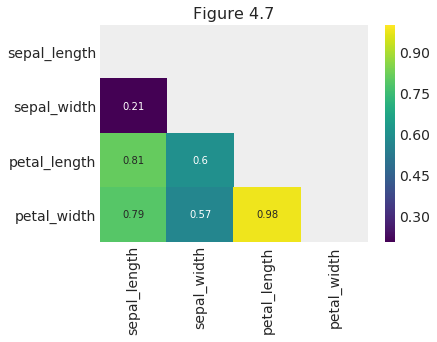

In [17]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.title('Figure 4.7');

Para generar la figura 4.7, hemos utilizado una máscara que elimina el triángulo superior y los elementos diagonales del _heatmap_, ya que estos son poco informativos o redundantes. Observe también que hemos graficado el valor absoluto de la correlación, ya que en este momento no nos importa el signo de la correlación entre las variables, solo su _fuerza_.

Una solución cuando se trabaja con variables (altamente) correlacionadas, es simplemente eliminar una (o más de una) de las variables correlacionadas. Otra opción es poner más información en el _a priori_, esto se puede lograr con _a prioris_ informativos si es que contamos con información previa útil, o más general utilizando _a prioris_ ligeramente informativos. Andrew Gelman y el equipo de Stan recomiendan usar el siguiente _a priori_ al realizar una regresión logística:

$$ \beta \sim Student t (0, \nu, sd) \tag {4.10}$$

donde `sd` se elije de forma que informe débilmente sobre los valores esperados para la escala. Se sugiere que el parámetro de normalidad $\nu$ sea alrededor de 3-7. Lo que dice este _a priori_ es que esperamos que el coeficiente sea pequeño, pero ponemos colas pesadas porque esto nos lleva a un modelo más robusto que el uso de una distribución gaussiana.

## Tratando con clases desequilibradas

El conjunto de datos del iris está completamente equilibrado; en el sentido de que cada categoría tiene exactamente el mismo número de observaciones. Tenemos 50 setosas, 50 versicolores, y 50 virgininas. Por el contrario, muchos conjuntos de datos constan de datos no balanceados, es decir, hay muchos más datos de una clase que de la otra. Cuando esto sucede, la regresión logística puede generar problemas, es decir, el límite no se puede determinar con la misma precisión que cuando el conjunto de datos está más equilibrado.


Para ver un ejemplo de este comportamiento, vamos a usar el conjunto de datos del iris y vamos a eliminar arbitrariamente algunos puntos de datos de la clase setosa:

In [18]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

Y ahora ejecutamos una regresión logística múltiple, tal cual hicimos antes.

In [19]:
with pm.Model() as modelo_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = pm.math.sigmoid(μ)
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 547.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


El límite de decisión se desplaza hacia la clase menos abundante y la incertidumbre es más grande que antes. Este es el comportamiento típico de un modelo logístico para datos no balanceados. ¡Pero espera un minuto! Bien podrías argumentar que te estoy engañando ya que la mayor incertidumbre es en realidad el producto de tener menos datos y no solo menos setosas que versicolores. Este es un punto totalmente válido, pero si realizas el ejercicio 2 podrás verificar que lo que explica esta gráfica son los datos desequilibrados.

Text(0.5, 1.0, 'Figure 4.8')

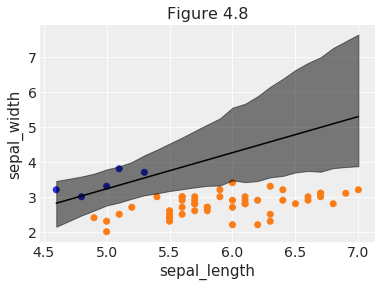

In [20]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k'); 
 
bd_hpd = pm.hpd(trace_3['bd'])[idx] 
plt.fill_between(x_3[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='k', alpha=0.5); 
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1]);

plt.title('Figure 4.8')

¿Qué hacer si encontramos datos desequilibrados? Bueno, la solución obvia es obtener un conjunto de datos con aproximadamente la misma cantidad por clase. Este es un punto a tener en cuenta al recopilar o generar los datos. Si no tenés control sobre el conjunto de datos, debes tener cuidado al interpretar los resultados para datos no balanceados. Verifique la incertidumbre del modelo y ejecute algunas verificaciones predictivas posteriores para ver si los resultados son útiles para usted. Otra opción sería utilizar _priors_ más informativos y/o ejecutar un modelo alternativo como se explica más adelante en este capítulo.

## Regresión softmax (o multinomial)


Una forma de generalizar la regresión logística a más de dos clases es con la **regresión softmax**. Necesitamos introducir 2 cambios con respecto a la regresión logística, primero reemplazamos la función logística con la función softmax:

$$softmax (\mu_i) = \frac {exp (\mu_i)} {\sum exp (\mu_k)} \tag{4.16}$$

En palabras, para obtener la salida de la función softmax para el i-esimo elemento de un vector $\mu$, tomamos la exponencial del valor i-esimo dividido por la suma de todos los valores del vector $\mu$ exponenciados.

La función softmax garantiza que obtendremos valores positivos que suman 1. La función softmax se reduce a la función logística cuando $k=2$. Como nota al margen, la función softmax tiene la misma forma que la **distribución de Boltzmann**, distribución central en la mecánica estadística, una rama muy poderosa de la física que se ocupa de la descripción probabilística de los sistemas atómicos y moleculares. La distribución de Boltzmann (y a veces la función softmax) incluye un parámetro llamado temperatura (T) que divide $\mu$; cuando $ T \rightarrow \infty $ la distribución de probabilidad se vuelve plana y todos los estados son igualmente probables, y cuando $T \rightarrow 0$ solo se llena el estado más probable y, por lo tanto, el softmax se comporta como la función máximo.

El segundo cambio en la regresión softmax es que reemplazamos la distribución de Bernoulli por la distribución categórica. La distribución categórica es la generalización de Bernoulli a más de dos resultados. Además, como la distribución de Bernoulli (tirada de una sola moneda) es un caso especial de la Binomial (tiradas de $n$ monedas), la categórica (tirada de un dado de $k$ caras) es un caso especial de la distribución multinomial ($n$ tiradas de un dado de $k$ caras). 


k-diagram

Para ejemplificar la regresión de softmax, continuaremos trabajando con el conjunto de datos iris, solo que esta vez usaremos sus 3 clases (setosa, versicolor y virginica) y sus cuatro características (largo sépalo, ancho sépalo, longitud del pétalo y ancho del pétalo). También vamos a estandarizar los datos, ya que esto ayudará a que el sampler se ejecute de manera más eficiente (también podríamos centrar los datos):

In [21]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

El código de PyMC3 refleja los pocos cambios entre el modelo logístico y el modelo softmax. Presta atención a los valores de `shape` para los coeficientes $\alpha $ y $\beta$. En el siguiente código usamos la función softmax de Theano. Hemos utilizado la expresión `import theano.tensor as tt`, que es la convención utilizada por los desarrolladores de PyMC3:

In [22]:
with pm.Model() as modelo_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:28<00:00, 176.82draws/s]
The acceptance probability does not match the target. It is 0.8797530785171586, but should be close to 0.8. Try to increase the number of tuning steps.


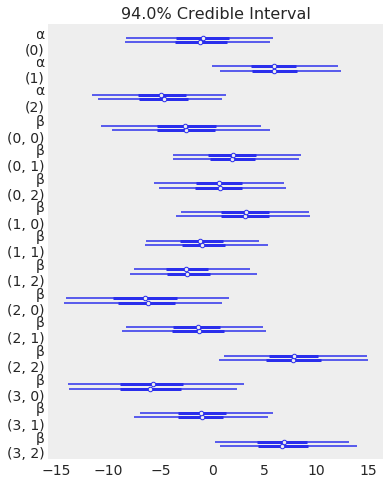

In [23]:
az.plot_forest(trace_s, var_names=['α', 'β']);

¿Qué tan bien funciona nuestro modelo? Averigüemos cuántos casos podemos predecir correctamente. En el siguiente código, solo usamos la media de los parámetros para calcular la probabilidad de que cada punto de datos pertenezca a cada una de las tres clases, luego asignamos la clase usando la función `argmax`. Y comparamos el resultado con los valores observados:

In [24]:
data_pred = trace_s['μ'].mean(0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

El resultado es que clasificamos correctamente $\approx 98 \%$ de los datos, es decir, clasificamos erroneamente solo tres casos. Ese es realmente un muy buen trabajo. Sin embargo, una verdadera prueba para evaluar el rendimiento de nuestro modelo sería verificarlo con un conjunto de datos no usado para ajustar al modelo. De lo contrario, es posible que estemos sobreestimando la capacidad _real_ del modelo para generalizar a otros datos.

Es posible que hayas notado que las distribuciones marginales de cada parámetro son muy amplias. Este es el mismo problema de no identificabilidad que ya hemos encontrado para los datos correlacionados en otros modelos de regresión o con clases perfectamente separables. En este caso, el ancho posterior se debe a la condición de que todas las probabilidades deben sumar 1. Dada esta condición, estamos usando más parámetros de los que necesitamos para especificar completamente el modelo. En términos simples, si tenés 10 números que suman 1, solo necesitás darme 9 de ellos; el otro puedo calcularlo. Esto es precisamente lo que está pasando con este problema. Una solución es fijar los parámetros _extra_ a algún valor, por ejemplo, cero. El siguiente código muestra cómo lograr esto usando PyMC3:

In [25]:
with pm.Model() as modelo_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 338.99draws/s]


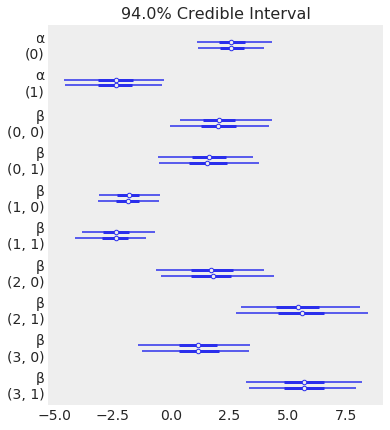

In [26]:
az.plot_forest(trace_sf, var_names=['α', 'β']);

## Linear discriminant analysis (LDA)

Hasta ahora hemos discutido la regresión logística y algunas extensiones de la misma. En todos estos casos, calculamos $p(y \mid x) $, es decir, la probabilidad que una clase $y$ teniendo como dato una o más variables $x$, luego usamos un umbral o límite para convertir la probabilidad computada  en un límite discreto lo que nos permite asignar clases.

Este enfoque no es único. Una alternativa es modelar primero $p(x \mid y)$. No vamos a entrar en mucho detalle aquí sobre este tipo de modelos para clasificación, pero vamos a ver un ejemplo que ilustra la idea central de este tipo de modelo. Lo haremos para dos clases y una sola variable, exactamente como el primer modelo que construimos en este capítulo, es más usaremos los mismos datos.

En el siguiente código se puede ver que ahora el límite de decisión se define como el promedio entre las medias de las Gaussianas. Este modelo es equivalente a lo que se conoce como análisis discriminante lineal (Linear Discriminar Analysis).

In [27]:
with pm.Model() as modelo_lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ, observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2152.89draws/s]


Ahora vamos a generar una figura que muestra las dos clases (`setosa = 0` y` versicolor = 1`) contra los valores de la longitud del sépalo, y también el límite de decisión como una línea naranja y el intervalo del 94% de HPD como una banda naranja semitransparente.

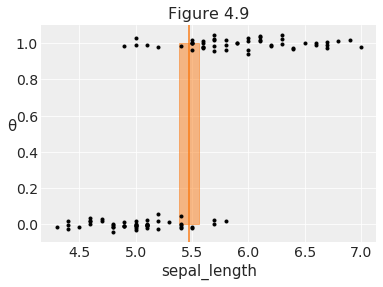

In [28]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.title('Figure 4.9');

Como habrá notado, la figura 4.9 es bastante similar a la figura 4.4. Verifique también los valores de la decisión de límite en el siguiente `summary`:

In [29]:
az.summary(trace_lda)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ[0],5.01,0.06,0.0,4.90,5.13,3132.0,1.0
μ[1],5.94,0.06,0.0,5.82,6.06,2270.0,1.0
σ,0.45,0.03,0.0,0.38,0.51,2716.0,1.0
bd,5.47,0.04,0.0,5.38,5.55,3009.0,1.0


Tanto el modelo LDA como la regresión logística proporcionan resultados similares. El modelo discriminante lineal puede extenderse a más de una característica al modelar las clases como Gaussianas multivariadas. Además, es posible relajar el supuesto de que las clases comparten una varianza común (o covarianza). Esto conduce a un modelo conocido como análisis discriminante cuadrático (QDA).

En general, los modelos LDA o QDA funcionarán mejor que una regresión logística cuando las características que estamos usando estén más o menos distribuidas como Gaussianas y la regresión logística funcionará mejor en el caso contrario. Una ventaja de modelos como LDA y QDA (o generalizaciones de esta idea) es que puede ser más fácil o más natural incorporar información previa.

Es importante tener en cuenta que los límites de decisión de LDA y QDA pueden ser calculados analíticamente y, por lo tanto, por lo general se calculan de esa manera. Para usar un LDA para dos clases y una característica, solo necesitamos calcular la media de cada distribución y promediar esos dos valores, y obtenemos la decisión de los límites. En el modelo anterior, lo hicimos, pero con un giro Bayesiano. Estimamos los parámetros de las dos Gaussianas y luego insertamos esas estimaciones en una fórmula predefinida. 

## Regresión de Poisson

Otro modelo lineal generalizado muy popular es la regresión de Poisson. Este modelo asume que los datos se distribuyen de acuerdo con la distribución de Poisson.

Un escenario en el que la distribución de Poisson es útil es cuando se analizan cosas, como la descomposición de un núcleo radioactivo, el número de hijos por pareja o el número de seguidores de Twitter. Lo que todos estos ejemplos tienen en común es que usualmente los modelamos usando números discretos no negativos {0, 1, 2, 3 ...}. Este tipo de variable recibe el nombre de datos de conteo (count data).

### La distribución de Poisson

Imagina que estamos contando la cantidad de autos rojos que pasan por una avenida por hora. Podríamos usar la distribución de Poisson para describir estos datos. La distribución de Poisson se utiliza generalmente para describir la probabilidad que ocurra un número determinado de eventos independientes entre si en un intervalo de tiempo o espacio fijo. Esta distribución discreta se parametriza utilizando solo un valor, $\mu$ (la tasa, también comúnmente representada con la letra griega $\lambda$). $\mu$ corresponde a la media y también a la varianza de la distribución. La función de probabilidad de masa de la distribución de Poisson es:

$$ f(x \mid \mu) = \frac {e^{-\mu}\mu^x} {x!} \tag{4.17}$$

dónde:
* $\mu$ es el número promedio de eventos por unidad de tiempo / espacio
* $x$ es un valor entero positivo 0, 1, 2, ...
* $x!$ es el factorial de x, k! = k × (k - 1) × (k - 2) × ... × 2 × 1

En la siguiente gráfica, podemos ver algunos ejemplos de la familia de distribución de Poisson, para diferentes valores de $\mu$.

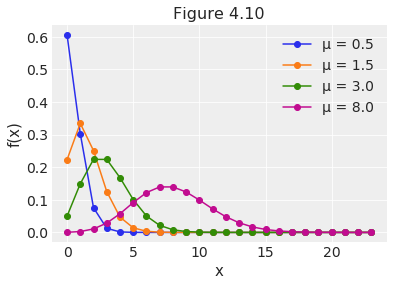

In [30]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Figure 4.10')
plt.savefig('B11197_04_10.png', dpi=300);

Es importante notar que $\mu$ puede ser un flotante, pero la distribución modela probabilidad de un número discreto de eventos. En la figura 4.10, los puntos representan los valores de la distribución, mientras que las líneas continuas son una ayuda visual que nos ayuda a comprender fácilmente la _forma_ de la distribución. Recuerde, la distribución de Poisson es una distribución discreta.

La distribución de Poisson puede verse como un caso especial de la distribución binomial cuando la cantidad de intentos $n$ es muy grande pero la probabilidad de éxito $p$ es muy baja. Sin entrar en detalles matemáticos, tratemos de aclarar la afirmación anterior. Siguiendo el ejemplo del auto, podemos afirmar que o vemos el auto rojo o no, por lo que podemos usar una distribución binomial. En ese caso tenemos:

$$ x \sim Bin(n, p) \tag{4.18}$$

Entonces, la media de la distribución binomial es:

$$\mathbf{E}[x] = np \tag{4.19} $$

Y la varianza viene dada por:

$$ \mathbf {V}[x] = np (1 - p) \tag{4.20}$$

Pero tenga en cuenta que incluso si se encuentra en una avenida muy transitada, la posibilidad de ver un auto rojo en comparación con el número total de automóviles en una ciudad es muy pequeño y, por lo tanto, tenemos:

$$n >> p \Rightarrow np \simeq np (1-p) \tag{4.21}$$

Entonces, podemos hacer la siguiente aproximación:

$$\mathbf {V}[x] = np \tag{4.22}$$

Ahora la media y la varianza están representadas por el mismo número y podemos
declarar con confianza que nuestra variable se distribuye como una distribución de Poisson:

$$x \sim Poisson(\mu = np) \tag{4.23}$$

## El modelo de Poisson inflado de ceros

Al contar cosas, una posibilidad es no contar esas cosas, es decir obtener cero. El número cero puede ocurrir generalmente por muchas razones; obtuvimos un cero porque estábamos contando autos rojos y un auto rojo no pasó por la avenida o porque no logramos verlo (tal vez no vimos pasar un diminuto auto rojo detrás de un gran camión). Entonces, si usamos una distribución de Poisson, notaremos, por ejemplo, cuando realizamos una verificación predictiva posterior, que el modelo generó menos ceros en comparación con los datos.

¿Cómo arreglamos eso? Podemos tratar de abordar la causa exacta por la cual nuestro modelo predice menos ceros de los observados e incluir ese factor en el modelo. Sin embargo, suele ser el caso, que es suficiente y más fácil para nuestro propósito, asumir que simplemente tenemos una mezcla de dos procesos:

* Uno modelado por una distribución de Poisson con probabilidad $\psi$
* Otra persona que da ceros adicionales con probabilidad $1 - \psi$.

Esto se conoce como modelo Poisson inflado de ceros (ZeroInflatedPoisson). En algunos textos, encontrarás que $\psi$ se usa para representar los ceros extra y $1-\psi$ la probabilidad de Poisson.

Básicamente una distribución ZIP nos dice que:

$$p(y_j = 0) = 1 - \psi + (\psi) e^{-\mu} \tag{4.24}$$

$$p(y_j = k_i ) = \psi \frac{\mu^x_i e^{-\mu}}{x_i!} \tag{4.25}$$ 

Donde $1-\psi$ es la probabilidad de ceros adicionales. Podríamos implementar fácilmente estas ecuaciones en un modelo PyMC3. Sin embargo, podemos hacer algo aún más fácil y usar la distribución ZIP de PyMC3.

In [31]:
#np.random.seed(42)
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * np.random.poisson(θ_real)
                   for i in range(n)])

In [32]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1., 1.)
    θ = pm.Gamma('θ', 2., 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ, observed=counts)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2005.06draws/s]


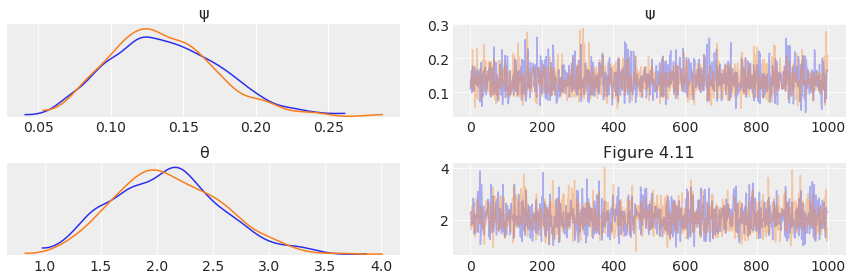

In [33]:
az.plot_trace(trace)
plt.title('Figure 4.11');

In [34]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
ψ,0.14,0.04,0.00,0.07,0.21,1665.0,1.0
θ,2.10,0.49,0.01,1.23,3.00,1704.0,1.0


## Regresión de Poisson y regresión ZIP

El modelo ZIP puede parecer un poco aburrido, pero a veces necesitamos estimar distribuciones simples como esta u otra como las distribuciones de Poisson o Gaussianas. Además, podemos usar las distribuciones Poisson o ZIP como parte de un modelo lineal. Como vimos con la regresión logística (y softmax) podemos usar una función de enlace inverso para transformar el resultado de un modelo lineal en una variable adecuada para ser utilizada con otra distribución que no sea la normal. En la siguiente figura, vemos una posible implementación de una regresión ZIP. La regresión de Poisson será similar, pero sin la necesidad de incluir $\phi$ ya que no modelaremos un exceso de ceros. Observe que ahora usamos la función exponencial como la función de enlace inverso. Esta elección garantiza que los valores devueltos por el modelo lineal sean positivos.

Para ejemplificar la implementación de un modelo de regresión ZIP, vamos a trabajar con un conjunto de datos tomado del [Instituto de Investigación y Educación Digital](http://www.ats.ucla.edu/stat/data).

El problema es el siguiente: trabajamos en la administración de un parque y queremos mejorar la experiencia de los visitantes. Por lo tanto, decidimos realizar una breve encuesta a 250 grupos que visitan el parque. Parte de los datos que recopilamos (a nivel de grupo) consiste en:

* La cantidad de peces que capturaron (contar)
* Cuántos niños había en el grupo (niño)
* Ya sea que hayan traído o no una casa-rodante o "caravana" al parque (camper).

Usando estos datos, vamos a construir un modelo que predice el número de peces capturados en función de las variables niño y caravana. Podemos usar Pandas para cargar los datos:

In [35]:
fish_data = pd.read_csv('datos/fish.csv')

Lo dejo como un ejercicio para que explore el conjunto de datos utilizando gráficos y / o una función de Pandas, como `describe()`. Por ahora vamos a continuar traduciendo el diagrama de Kruschke anterior a PyMC3:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 691.76draws/s]


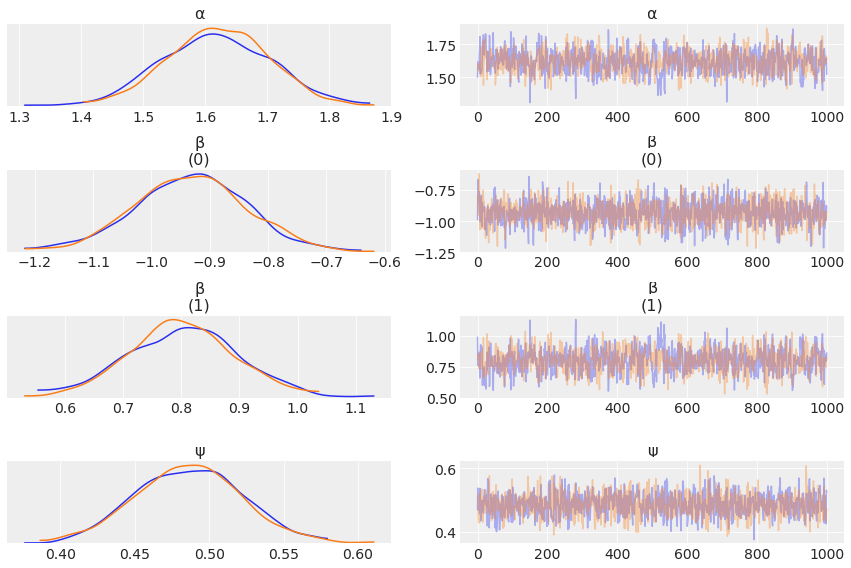

In [36]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000)
az.plot_trace(trace_ZIP_reg);

Para entender mejor los resultados de nuestra inferencia, hagamos una gráfica.

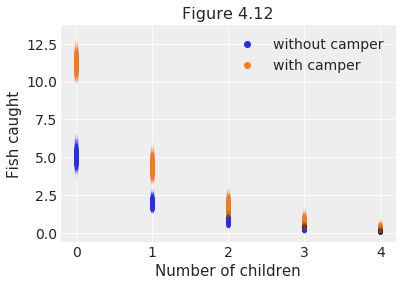

In [37]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend();
plt.title('Figure 4.12');

## Regresión logística robusta

Acabamos de ver cómo corregir un exceso de ceros sin modelar directamente el factor que los genera. Se puede utilizar un enfoque similar, sugerido por Kruschke, para realizar una versión más robusta de la regresión logística. Recuerde que en la regresión logística modelamos los datos como binomiales, es decir, ceros y unos. Por lo tanto, puede suceder que encontremos un conjunto de datos con ceros y/o unos inusuales. Tomemos como ejemplo el conjunto de datos de iris que ya hemos visto, pero con algunos _datos intrusos_ agregados de manera deliberada:

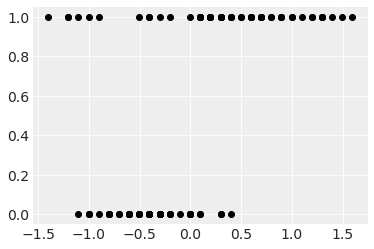

In [38]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

Aquí tenemos algunas versicolors (1s) con una longitud de sépalo inusualmente corta. Podemos arreglar esto con un modelo de mezcla. Vamos a decir que la variable de salida viene con probabilidad $\pi$ por adivinación aleatoria o con probabilidad $1-\pi$ de un modelo de regresión logística. Matemáticamente, tenemos:

$$p = \pi \ 0.5 + (1 - \pi) \: \text{logistic}(\alpha + X \beta) \tag{4.26} $$


Tenga en cuenta que cuando $\pi = 1$ obtenemos $p = 0.5 $, y para $\pi = 0 $ recuperamos la expresión para regresión logística.

La implementación de este modelo es una modificación directa del primer modelo de este capítulo.

In [39]:
with pm.Model() as modelo_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1, 1) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1559.75draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [40]:
az.summary(trace_rlg, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-0.77,0.95,0.03,-2.40,1.14,878.0,1.0
β,15.69,6.47,0.29,5.47,27.55,642.0,1.0


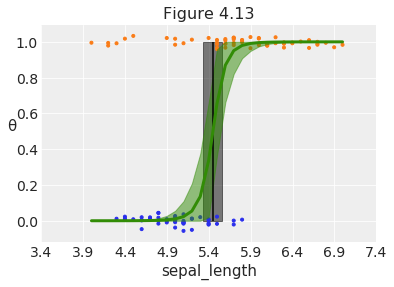

In [41]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = pm.hpd(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.title('Figure 4.13');

## Ejercicios

1. Vuelva a correr el `modelo_0` pero esta vez usando las variables `petal_length` y `petal_width` ¿En que difieren los resultados? ¿Cuán ancho o angosto es el intervalo hpd 94%? 

2. Repita el ejercicio 1, esta vez usando una distribución t de Student como _prior ligeramente informativo_. Pruebe con distintos valores de $\nu$.

3. Use un modelo lineal (como los vistos en el capítulo anterior) para  clasificar setosa o versicolor en función de `sepal_length`. ¿Cuán útil es este modelo comparado con una regresión logística? 

4. En la sección _Interpretando los coeficientes de una regresion logística_ vimos el efecto sobre el `log_odds` de cambiar la variable `sepal_length` en 1 unidad. Usando la figura 4.6 corrobore que el valor obtenido para `log_odds_versicolor_i` se corresponde con el valor de `probability_versicolor_i`. Haga lo mismo para `log_odds_versicolor_f` y `probability_versicolor_f`. Si solo sabemos que el valor de `log_odds_versicolor` es negativo que podemos decir de la probabilidad de versicolor, use la figura 4.6 como guía ¿Es este resultado evidente de la definición de log-odds?

5. Para `modelo_1` verifica cuanto cambian el valor de log-odd al incrementar `sepal_leght` de 5.5 a 6.5. ¿Cúal es el cambio en valores de probabilidad? ¿Cuál es el cambio en términos de log-odds y probabilidad al pasar de 4.5 a 5.5?

6. En el ejemplo de clases desbalanceadas cambie `df = df[45:]` por `df = df[22:78]`. Esto dejará más o menos el mismo número de datos, pero con las clases balanceadas. Compare con los resultados previos. ¿Cuál caso es más parecido a usar el conjunto de datos completo?

7. Suponga que en vez de usar una regresión softmax usamos un modelo lineal simple codificando $\text{setosa}=0$, $\text{versicolor}=1$ y $\text{virginica}=1$. Bajo el modelo lineal simple que pasaría si cambiáramos el orden del código.

8. Compara los likelihoods para el `modelo_0` y para el `modelo_lda`. Usa la función `pm.sample_posterior_predictive` para generar datos a partir de estos dos modelos. ¿En que difirien los datos predichos para ambos modelos?

9. Extienda el modelo `ZIP_reg` para incluir la variable `persons`. Usa esta variable para modelar el número de ceros extra. Deberás obtener un modelo que incluya dos modelos lineales, uno que conecte las variables `children` y `camper` a la tasa de Poisson y otro que conecte el número de personas con la variable $\psi$. Presta atención si es necesario usar una función inversa de enlace.

10. Use los datos empleados en el ejemplo de la regresión logística robusta con un modelo de regresión logística simple. ¿Cuál es el efecto de los _outliers_? Pruebe agregando o eliminado _outliers_.